## EDA FOR UNIVARIATE TIME SERIES

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import datetime
import calendar
import os
import random
import statsmodels.api as sm
from numpy import sqrt
from numpy import log
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox
from arch.unitroot import ADF
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from arch.unitroot import DFGLS
from pmdarima.arima import OCSBTest
from pmdarima.arima import CHTest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson
from matplotlib import pyplot
from pandas.plotting import lag_plot
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


In [71]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D"

file_name = "order_product_merged_file (1).csv"
time_dependent_variable = "Total Sales Units consolidated"
time_column = "Order Date"
frmt                    = "%Y-%m-%d"
X                       = "D"


## Read the dataset

In [72]:
def data(time_column, file_name, frmt='%Y-%m-%d %H:%M:%S', X="D"):

    if ".csv" in file_name:
        df = pd.read_csv(file_name, parse_dates=True)
    elif ".xlsx" in file_name:
        df = pd.read_excel(file_name, parse_dates=True)
        
    df = df.drop_duplicates()
    df = df[[time_column, time_dependent_variable]]
    df[time_column] = pd.to_datetime(df[time_column], format=frmt)
    df.index = df[time_column]
    df = df.resample(X)
    df = pd.DataFrame(df[time_dependent_variable].sum()).reset_index()
    return df


df = data(time_column, file_name, frmt, X)


In [73]:
df = df[df["Order Date"] >= '2020-07-27']
df.shape

(523, 2)

In [74]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing(% of Total values)'] = (
        100 * summary['Missing']) / df.shape[0]
    summary['Uniques'] = df.nunique().values
    # summary['First Value'] = df.loc[0].values
    # summary['Second Value'] = df.loc[1].values
    return summary
    
resumetable(df)

Dataset Shape: (523, 2)


,Name,dtypes,Missing,Missing(% of Total values),Uniques
0,Order Date,datetime64[ns],0,0.0,523
1,Total Sales Units consolidated,int64,0,0.0,252


In [75]:
def describe(df):
    return df.describe().T
    
describe(df)

,count,mean,std,min,25%,50%,75%,max
Total Sales Units consolidated,523.0,139.08413,358.903477,0.0,20.0,83.0,174.0,7681.0


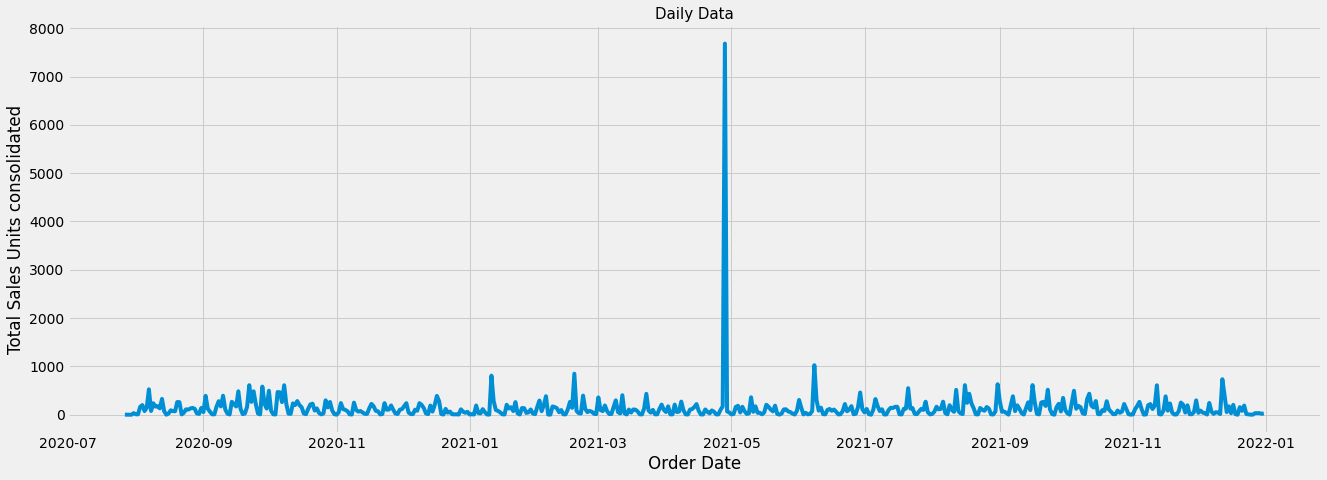

In [76]:
# Plot the Time series data
def graph(df,time_column, time_dependent_variable):
    fig, ax = plt.subplots(figsize=(20, 7))
    a = sns.lineplot(x=time_column, y=time_dependent_variable, data=df)
    a.set_title("Daily Data", fontsize=15)
    plt.show()

graph(df,time_column, time_dependent_variable)

Creates time series features from Date column.

In [77]:
def date_features(df, time_column, time_dependent_variable):
    df = df.copy()
    df['month'] = df[time_column].dt.strftime('%B')
    df['year'] = df[time_column].dt.strftime('%Y')
    df['dayofweek'] = df[time_column].dt.strftime('%A')
    df['quarter'] = df[time_column].dt.quarter
    df['dayofyear'] = df[time_column].dt.dayofyear
    df['dayofmonth'] = df[time_column].dt.day
    df['weekofyear'] = df[time_column].dt.weekofyear
    return df


df_new = date_features(df, time_column, time_dependent_variable)
df_new.columns


Index(['Order Date', 'Total Sales Units consolidated', 'month', 'year',
       'dayofweek', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

### Plotting the Features to see trends

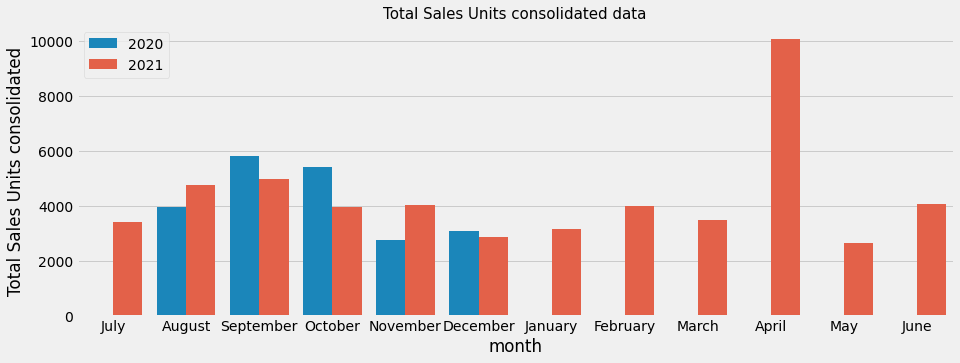

In [79]:
def eda(time_column, time_dependent_variable):
    fig, ax = plt.subplots(figsize=(14, 5))
    palette = sns.color_palette("mako_r", 4)
    a = sns.barplot(x="month", y=time_dependent_variable,
                    hue='year', data=df_new, ci=None, estimator=sum)
    a.set_title(time_dependent_variable+" " + "data", fontsize=15)
    plt.legend(loc="best")
    plt.show()


eda(time_column, time_dependent_variable)


Aggregated EDA of the MetaData

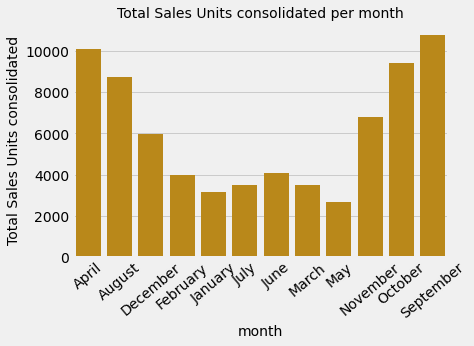

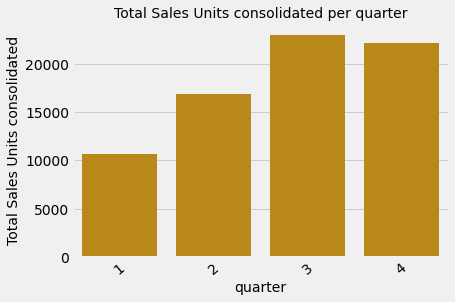

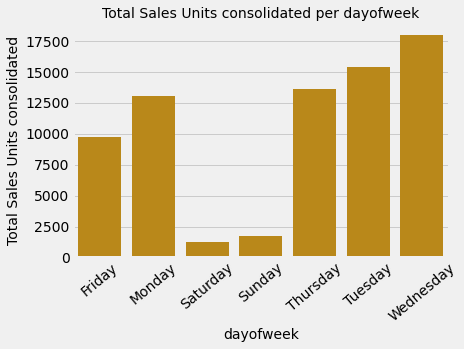

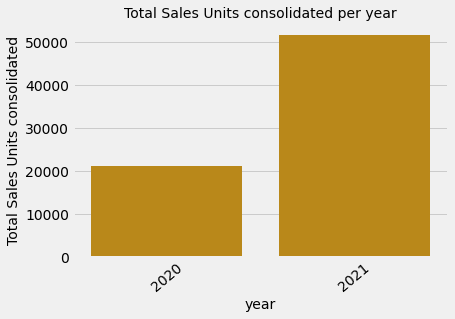

In [80]:
def aggregated_eda(time_feature, rotation=40, color="#D39200"):
    plt.xticks(rotation=rotation)

    x = df_new.groupby([time_feature], as_index=False).agg(
        {time_dependent_variable: 'sum'})
    sns.barplot(x=x[time_feature], y=time_dependent_variable,
                data=x, color=color)
    plt.xticks(rotation=rotation)
    plt.title(time_dependent_variable + " " +
              "per " + time_feature, fontsize=14)
    plt.ylabel(time_dependent_variable, fontsize=14)
    plt.xlabel(time_feature, fontsize=14)
    plt.show()
    del x


for time_feature in ["month", "quarter", "dayofweek", "year"]:
    aggregated_eda(time_feature)


## Visualization Plots (Univariate)

### Line plots

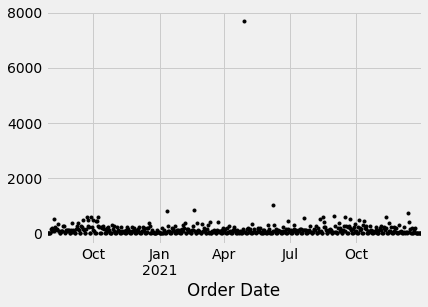

In [81]:
def line_plots(df,time_dependent_variable,method):
    df.index = df[time_column]
    if method == "scatter":
        df[time_dependent_variable].plot(style='k.')
        return pyplot.show()
    elif method == "line":
        df[time_dependent_variable].plot()
        return pyplot.show()
    elif method == "histogram":
        df[time_dependent_variable].hist()
        return pyplot.show()
    elif method == "density":
        df[time_dependent_variable].plot(kind='kde')
        return pyplot.show()


line_plots(df,time_dependent_variable,"scatter")

### Lag Scatter Plots

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

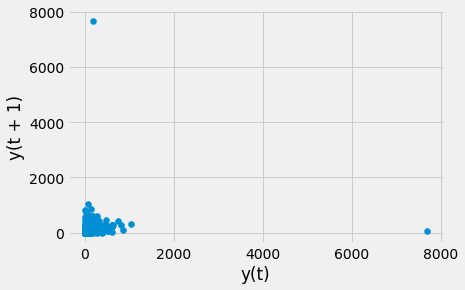

In [85]:
lag_plot(df[time_dependent_variable],1)

## Pattern with Metadata

### Exploring quarterly pattern if any:

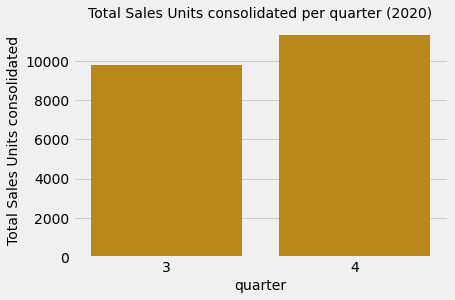

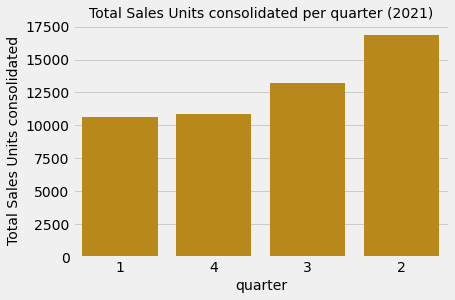

In [86]:
def quarterly_pattern_over_years(time_column, time_dependent_variable, rotation=0, color="#D39200"):
    for year in df[time_column].dt.year.unique():
        # Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        # Extracting month name from date
        x['quarter'] = x[time_column].dt.quarter

        # Grouping data by months and adding time_dependent_variable
        x = x.groupby(['quarter'], as_index=False).agg(
            {time_dependent_variable: 'sum'})

        # Plotting month Vs time_dependent_variable for every year
        # plt.figure(figsize=(12,8))
        sns.barplot(x=x.quarter, y=time_dependent_variable, data=x, order=x.sort_values(
            time_dependent_variable).quarter, color=color)
        plt.xticks(rotation=rotation)
        plt.title(time_dependent_variable + " " +
                  "per quarter ("+str(year)+")", fontsize=14)
        plt.ylabel(time_dependent_variable, fontsize=14)
        plt.xlabel('quarter', fontsize=14)
        plt.show()
        del x

quarterly_pattern_over_years(time_column, time_dependent_variable)

### Exploring monthly pattern if any:

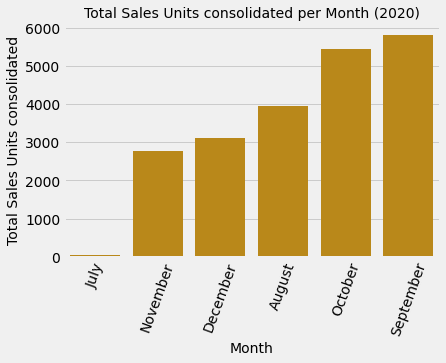

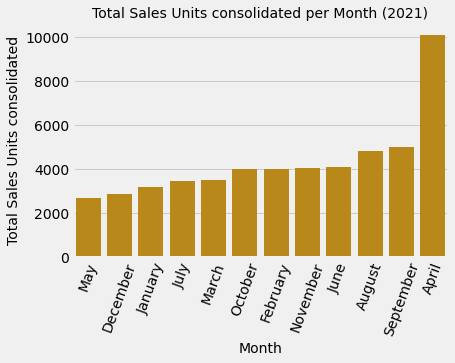

In [87]:
def monthly_pattern_over_years(time_column, time_dependent_variable, rotation=70, color="#D39200"):
    for year in df[time_column].dt.year.unique():
        # Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        # Extracting month name from date
        x['month'] = x[time_column].dt.month_name()

        # Grouping data by months and adding time_dependent_variable
        x = x.groupby(['month'], as_index=False).agg(
            {time_dependent_variable: 'sum'})

        # Plotting month Vs time_dependent_variable for every year
        # plt.figure(figsize=(12,8))
        sns.barplot(x=x.month, y=time_dependent_variable, data=x, order=x.sort_values(
            time_dependent_variable).month, color=color)
        plt.xticks(rotation=rotation)
        plt.title(time_dependent_variable + " " +
                  "per Month ("+str(year)+")", fontsize=14)
        plt.ylabel(time_dependent_variable, fontsize=14)
        plt.xlabel('Month', fontsize=14)
        plt.show()
        del x


monthly_pattern_over_years(time_column, time_dependent_variable)


### Exploring weekly pattern if any:

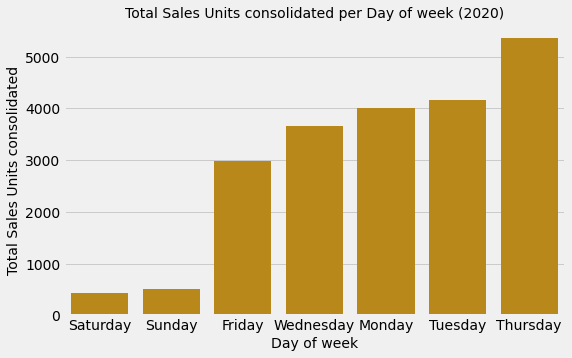

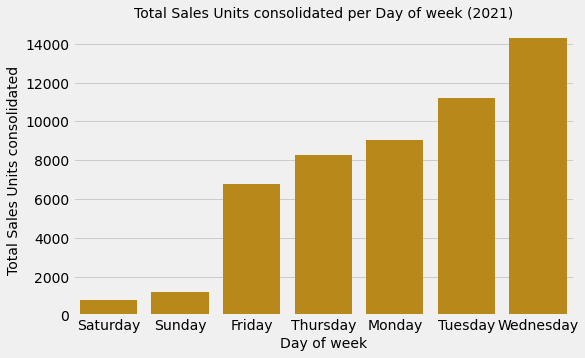

In [88]:
def weekly_pattern_over_years(time_column, time_dependent_variable, rotation=70, color="#D39200"):
    for year in df[time_column].dt.year.unique():

        # Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        # Adding Day of Week as a Feature
        x['day_of_week'] = x[time_column].dt.day_name()

        # Group By day_of_week and Sum of time_dependent_variable for each day_of_week
        x = x.groupby(['day_of_week'], as_index=False).agg(
            {time_dependent_variable: 'sum'})

        # Plotting day_of_week Vs time_dependent_variable
        plt.figure(figsize=(8, 5))
        sns.barplot(x=x.day_of_week, y=time_dependent_variable, data=x, order=x.sort_values(
            time_dependent_variable).day_of_week, color=color)
        plt.title(time_dependent_variable+" " +
                  "per Day of week ("+str(year)+")", fontsize=14)
        plt.xlabel('Day of week', fontsize=14)
        plt.ylabel(time_dependent_variable, fontsize=14)

        del x


weekly_pattern_over_years(time_column, time_dependent_variable)


## Seasonal Decomposition (time_dependent_variable)

In [90]:
def density_plt_(time_dependent_variable, dataset=df):
    plt.figure(figsize=(12, 6))
    sns.distplot(dataset[time_dependent_variable])
    plt.show()

# Decomposition
def decomp_plt_(time_dependent_variable, dataset=df, period=12,  model='additive'):
    decomposition = seasonal_decompose(dataset[time_dependent_variable], period=period, model=model)  # Can't handle missing data
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset[time_dependent_variable], label='Original', color='b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color='b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal, label='Seasonality', color='b')
    ax.legend(loc='best')
    ax = fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color='b')
    ax.legend(loc='best')
    plt.show()


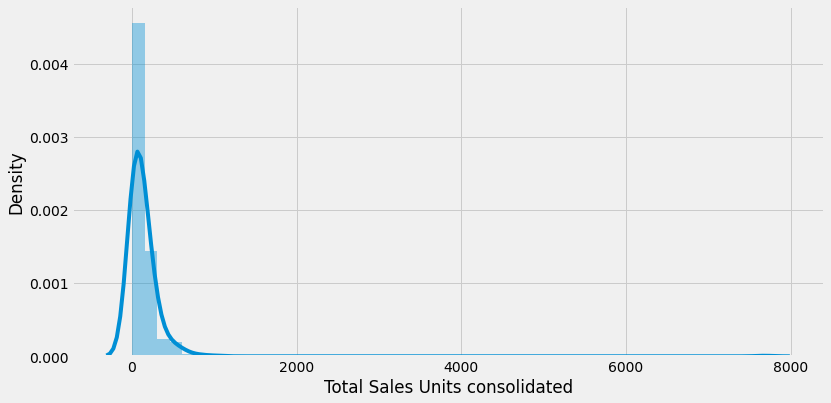

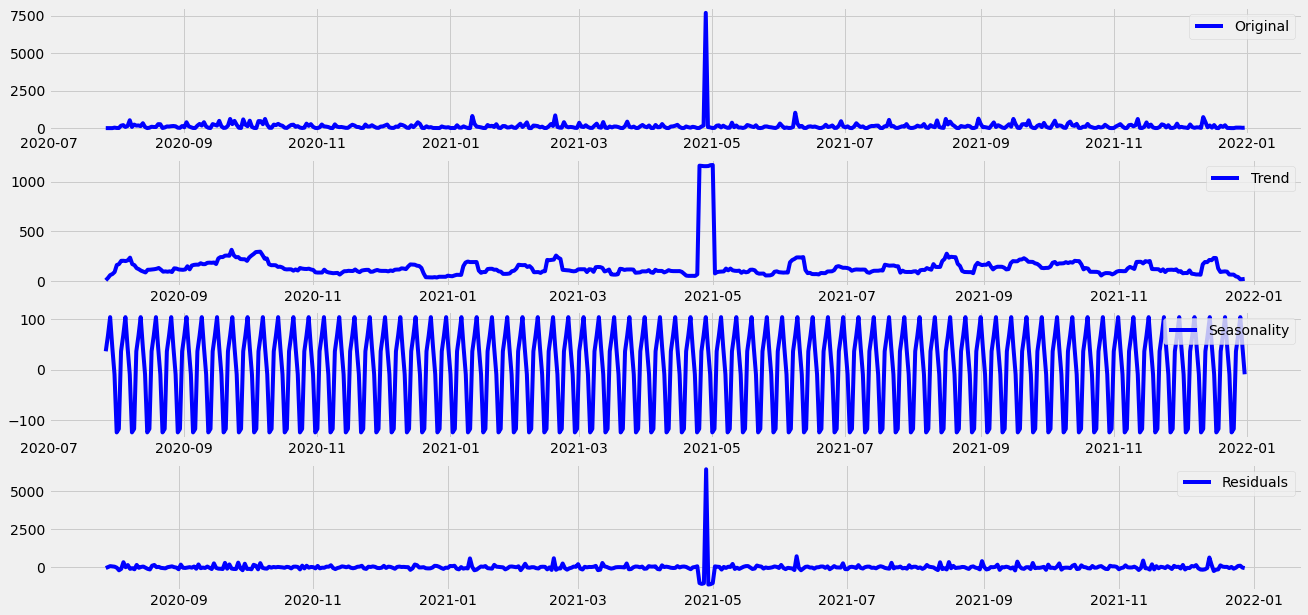

In [94]:
density_plt_(time_dependent_variable)
decomp_plt_(time_dependent_variable, df, period=7, model="additive")


### Configuring AR and MA

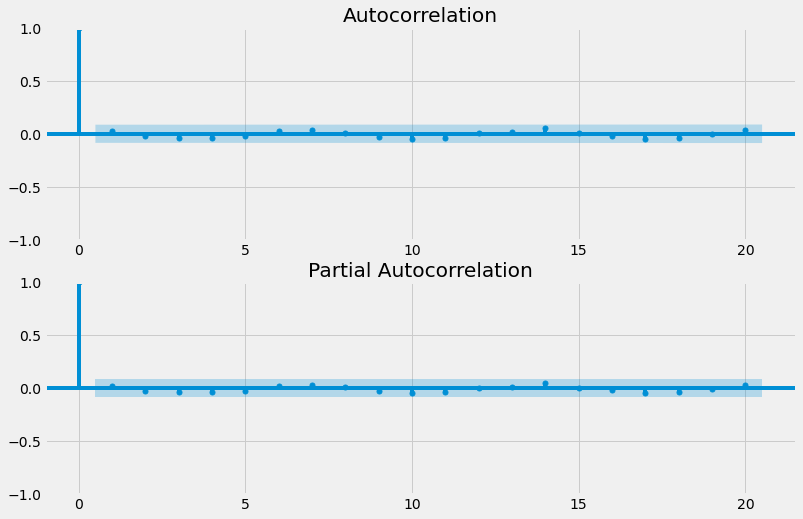

In [95]:
# ACF  -> It is a function that provides you with the information of how much a series is autocorrelated with its lagged values.
#         In simple terms, it describes how well the present value of the series is related with its past values.
# PACF -> It is another important function that finds correlation of the residuals with the next lag. It is a function that
#         measures the incremental benefit of adding another lag. So if through the PACF function we discover that there
#         is hidden information in the residual that can be modeled by the next lag, we will keep that next lag as a feature
#         while modeling.
# BOOK -> https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/0/6796/files/2017/03/analysis-of-financial-time-series-copy-2ffgm3v.pdf

def acf_pacf_plot(df, time_dependent_variable, lags=40):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df[time_dependent_variable], lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df[time_dependent_variable], lags=lags, ax=ax2)  # lags=40


acf_pacf_plot(df, time_dependent_variable, lags=20)


### Plot Rolling Mean and Standard deviation

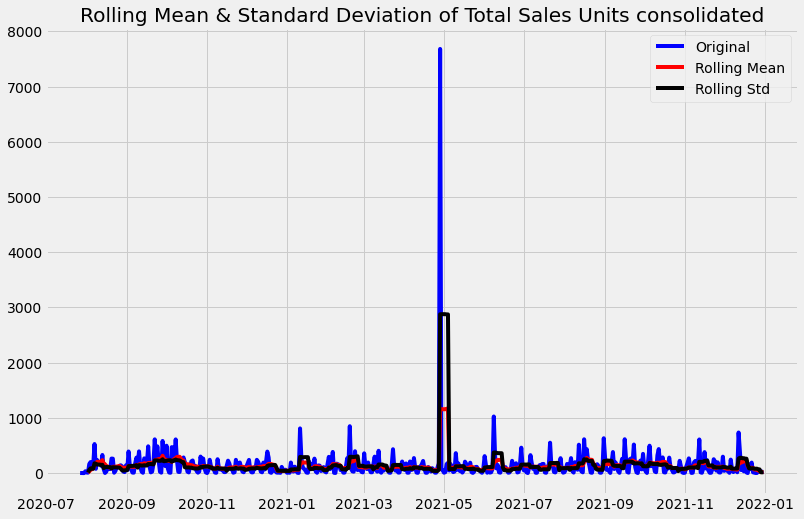

In [96]:
def plot_rolling_mean_sd(window,df,time_dependent_variable):
    # Determing rolling statistics
    rolmean = df[time_dependent_variable].rolling(window).mean()
    rolstd = df[time_dependent_variable].rolling(window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(df[time_dependent_variable],
                    color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of ' +
              time_dependent_variable)
    plt.show()


plot_rolling_mean_sd(7,df,time_dependent_variable)

## Stationarity Tests

### Augmented Dickey-Fuller test

In [97]:
def adf_test(df, time_dependent_variable, trend="ct", lags=10, method="AIC"):
    adf = ADF(df[time_dependent_variable],
              trend=trend, lags=lags, method=method)
    # reg_res = adf.regression #---- if you need regression results we can get it from here
    # print(reg_res.summary().as_text())
    if adf.pvalue < 0.01:
        return 1
    else :
        return 0
    
adf_test(df, time_dependent_variable)

1

### KPSS test

In [98]:
def kpss_test(df, time_dependent_variable, trend="ct", lags=10):
    kpss = KPSS(df[time_dependent_variable], trend=trend, lags=lags)
    if kpss.pvalue > 0.01:
        return 1
    else :
        return 0

kpss_test(df, time_dependent_variable)

1

### Phillips-Perron test

In [34]:
def PhillipsPerron_test(df, time_dependent_variable, lags=10, trend="ct", test_type="tau"):
    pp = PhillipsPerron(df[time_dependent_variable],
                        lags=lags, trend=trend, test_type=test_type)
    print(pp.summary().as_text())

PhillipsPerron_test(df, time_dependent_variable )

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.949
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.62 (1%), -3.71 (5%), -3.30 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### Dickey-fuller GLS Test

In [35]:
def dfgls_test(df, time_dependent_variable, trend="ct", lags=10, method="AIC"):
    dfgls = DFGLS(df[time_dependent_variable],
                  trend=trend, lags=lags, method=method)
    print(dfgls.summary().as_text())

dfgls_test(df, time_dependent_variable)

      Dickey-Fuller GLS Results      
Test Statistic                 -0.000
P-value                         0.995
Lags                               10
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -8.33 (1%), -6.26 (5%), -5.41 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Seasonality tests

### 1) OCSB test
Compute the Osborn, Chui, Smith, and Birchenhall (OCSB) test for an input time series to determine whether it needs seasonal differencing

In [36]:
# 'm' provides info on seasonality.

# Null hypothesis: the series contains a seasonal unit root
# Alternative hypothesis : this series is seasonal stationary 

def OCSB_test(df, time_dependent_variable, m, lag_method='aic', max_lag=3):
    OCSB = OCSBTest(m=m, lag_method=lag_method, max_lag=max_lag).estimate_seasonal_differencing_term(
        df[time_dependent_variable])
    print(OCSB)

OCSB_test(df, time_dependent_variable, m=7)

1


### 2) CH Test

In [37]:
# 'm' provides info on seasonality. 

# Null hypothesis : seasonal pattern is stable over a sample period
# Alternative hypothesis : it is not stable over time

def CH_test(df, time_dependent_variable, m):
    CH = CHTest(m=m).estimate_seasonal_differencing_term(
        df[time_dependent_variable])
    print(CH)

CH_test(df, time_dependent_variable, m=7)

0


## Making time series Stationary and Seasonal Stationary

### Diffencing using Augmented Dickey-Fuller test and KPSS test

In [102]:
# Differencing the time series is one of widely used remedies for making the series stationary. The function below performs the
# differencing based on the Augmented Dickey-Fuller test to make the time series stationary. In other words, it finds the
# smallest value of differencing level which makes the series stationary.
# yo,y1,y2->y1-y0,y2-y1-> y2-2*y1+y0 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def make_stationary(df, time_dependent_variable, alpha = 0.05, max_diff_order= 3):
    # Test to see if the time series is already stationary
    if (adfuller(df[time_dependent_variable])[1] < alpha) and (kpss(df[time_dependent_variable])[1] > alpha):
        return {
            'differencing_order': 0,
            'time_series': df[time_dependent_variable]
        }
    
    # A list to store P-Values
    p_values = []
    
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        adf_result = adfuller(np.diff(df[time_dependent_variable],n=i))
        kpss_result = kpss(np.diff(df[time_dependent_variable],n=i))
        # Append P-value
        p_values.append((i,adf_result[1],kpss_result[1]))
        
    # Keep only those where P-value (adf) is lower than alpha and p-value(kpss) is higher than alpha
    significant = [p for p in p_values if (p[1] < alpha) and (p[2] > alpha)]
    # Sort by the differencing order
    significant = sorted(significant, key=lambda x: x[0])
    
    # Get the differencing order
    diff_order = significant[0][0]
    
    # Make the time series stationary
    stationary_series = pd.Series(np.diff(df[time_dependent_variable],n=diff_order))
    
    return {
        'differencing_order': diff_order,
        'time_series': stationary_series
    }

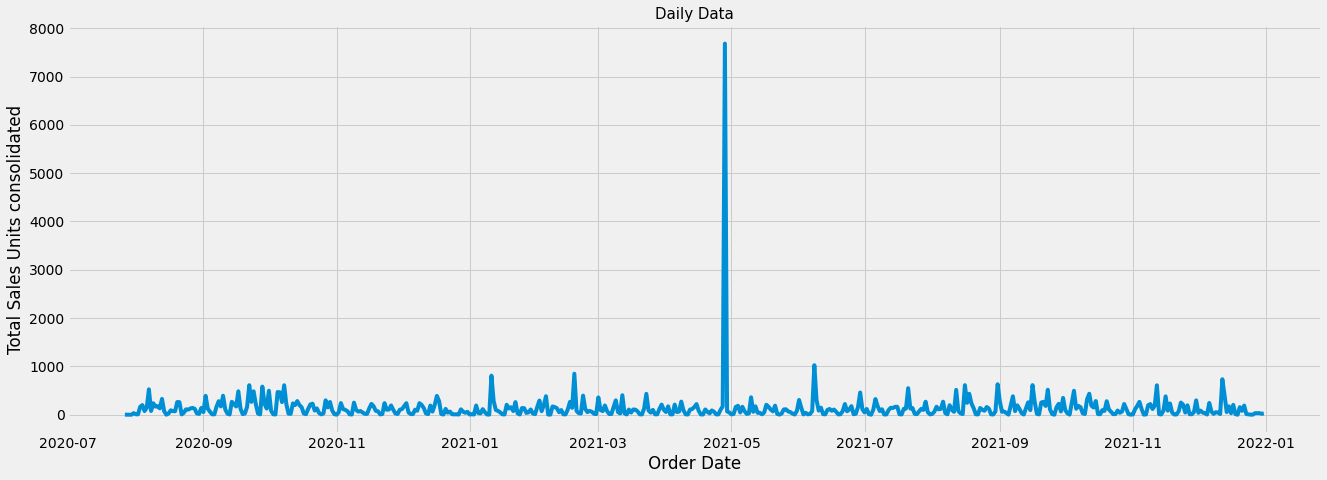

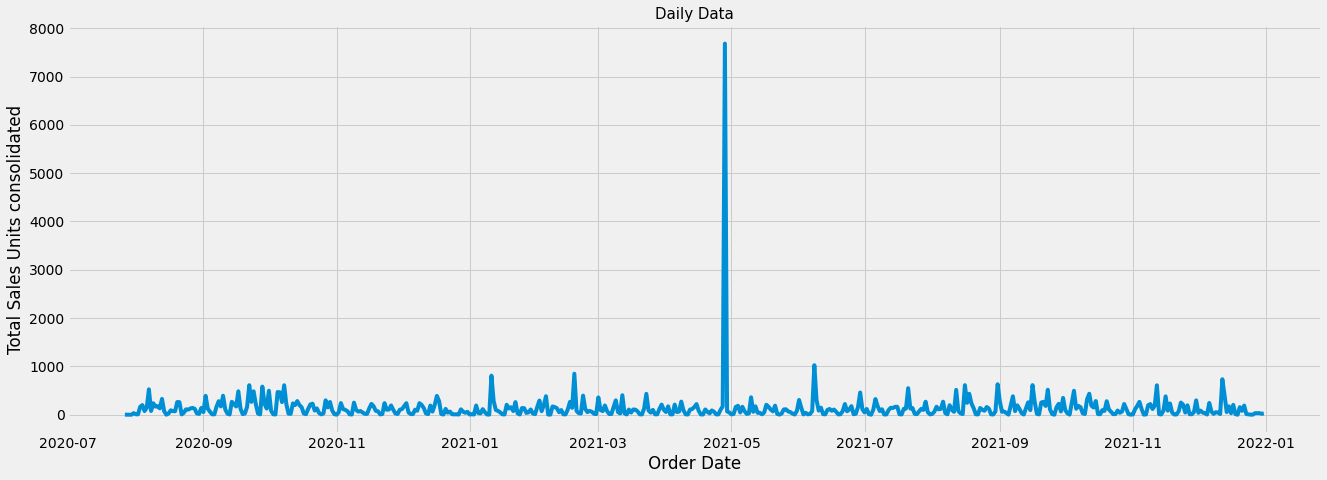

In [103]:
stationary_series = pd.DataFrame(make_stationary(df, time_dependent_variable)["time_series"])
graph(stationary_series,stationary_series.index,time_dependent_variable)
graph(df,df[time_column],time_dependent_variable)

### Seasonal Differencing using CH and OSCB tests

In [104]:
# The function below performs the seasonal differencing based on CH and OSCB tests to make the time series seasonal stationary.
# A seasonal difference is the difference between an observation and the corresponding observation from a previous year.
# y'(t) = y(t) − y(t−m)

def make_seasonal_stationary(df,time_dependent_variable,m):
        # Test to see if the time series is already seasonal stationary stationary
    if (CHTest(m=m).estimate_seasonal_differencing_term(df[time_dependent_variable]) == 0) and (OCSBTest(m=m, lag_method="aic", max_lag=3).estimate_seasonal_differencing_term(
        df[time_dependent_variable]) == 0) :
        return {
            'differencing_order': 0,
            'time_series': df[time_dependent_variable]
        }
    else :
        return {
            'differencing_order': m,
            'time_series' : df[time_dependent_variable].diff(m).dropna()
        }   

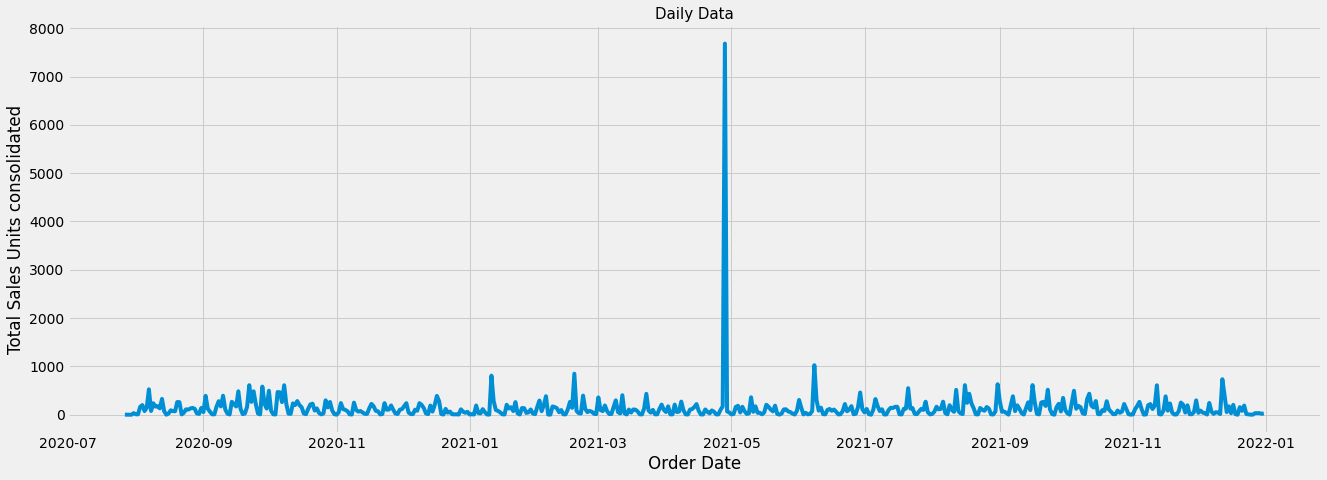

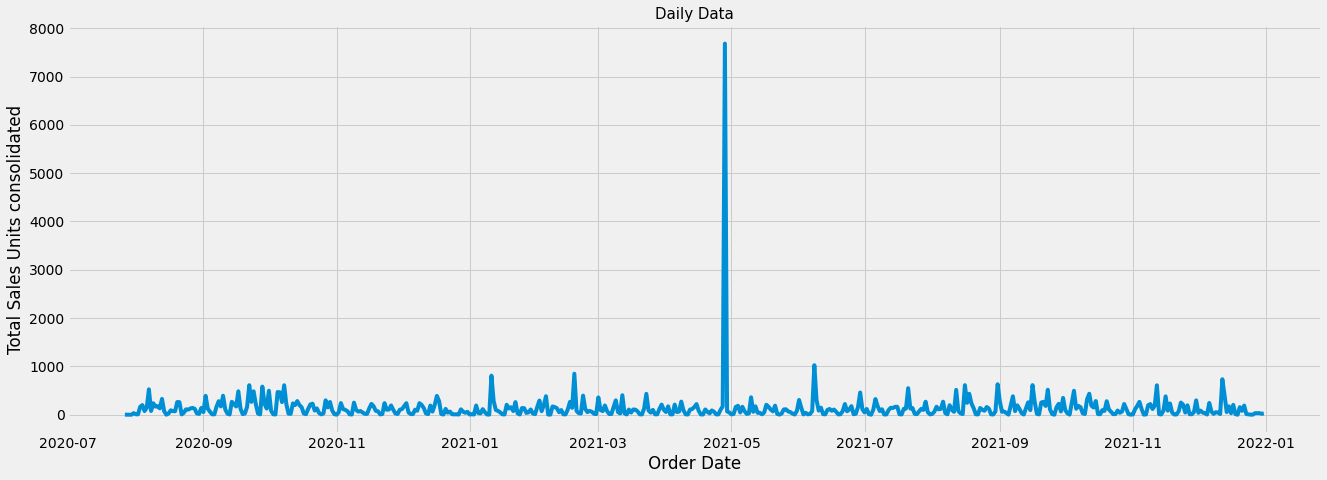

In [105]:
seasonal_stationary_series = pd.DataFrame(make_seasonal_stationary(df,time_dependent_variable,m=7)["time_series"])
graph(seasonal_stationary_series,seasonal_stationary_series.index,time_dependent_variable)
graph(df,df[time_column],time_dependent_variable)

## Test for Autocorrelation from Regression

### 1) Ljung-box test and  Box-Pierce test

In [106]:
# Ho : There is no autocorrelation between the signal and its lagged version
# H1 : There is significant autocorrelation between the signal and its lagged version

# model_df is your degrees of freedom. For example if we are using ARMA model then df would be p+q.

def ljung_test(residuals,model_df,lags=10):
    ljung = acorr_ljungbox(residuals, lags=lags, boxpierce=True, model_df=model_df, period=None, return_df=True) 
    return ljung

ljung_test(df[time_dependent_variable],0)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.314982,0.574639,0.313182,0.575734
2,0.618270,0.734082,0.614159,0.735592
3,1.404261,0.704536,1.392664,0.707255
4,2.095108,0.718271,2.075616,0.721853
5,2.344346,0.799732,2.321531,0.803099
6,2.590191,0.858240,2.563630,0.861280
7,3.216926,0.864236,3.179621,0.867903
8,3.286494,0.915114,3.247864,0.917854
9,3.651740,0.932805,3.605457,0.935413
10,4.771150,0.905932,4.699280,0.910340


### 2) Breusch Godfrey Test

In [66]:
# H0 (null hypothesis): There is no autocorrelation at any order less than or equal to p.
# H1 (alternative hypothesis): There exists autocorrelation at some order less than or equal to p.

# The test statistic follows a Chi-Square distribution with p degrees of freedom. This only supports one dimension
# of errors. Here, residuals are from the regression after fitting the model.

def Breusch_godfrey_test(residuals,lags=10):
    breusch = acorr_breusch_godfrey(residuals, nlags=lags)
    return breusch

### 3) Watson Durbin Test

In [67]:
# H0 (Null Hypothesis) : There is no serial correlation in the residuals.
# H1 (Alternative Hypothesis) : There is serial correlation in the residuals.

# If data has more dimensions then you can increase the axis from zero.
# This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for
# positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

def Watson_Durbin_test(residuals,axis=0):
    dw = durbin_watson(residuals, axis=axis)
    return dw

Watson_Durbin_test(df[time_dependent_variable])

0.36654859871900314

## Methods to deal with Variance Invariance

### 1) Square-Root Transform

In [99]:
def sqrt_transform(df,time_dependent_variable):
    return sqrt(df[time_dependent_variable])

### 2) Log-Transform method

In [100]:
# Won't work if you have zero in your data..try taking log after adding a constant -> log(series + constant)

def log_transform(df,time_dependent_variable):
    return log(df[time_dependent_variable])

### 3) Box-Cox transform method

In [101]:
# Below are some common values for lambda:
# lambda = -1. is a reciprocal transform.
# lambda = -0.5 is a reciprocal square root transform.
# lambda = 0.0 is a log transform.
# lambda = 0.5 is a square root transform.
# lambda = 1.0 is no transform.

def box_cox_transform(df,time_dependent_variable,lmbda):
    return boxcox(df[time_dependent_variable],lmbda=lmbda)